In [1]:
# ## BGG API
# https://www.boardgamegeek.com/xmlapi2/thing?id=161599&comments=1
# https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame
# ## NLP WITH TF
# https://www.tensorflow.org/hub/tutorials/tf2_text_classification

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import xml.etree.ElementTree as Xet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from IPython.display import Image, HTML

from langdetect import detect
import re

print("Version:     ", tf.__version__)
print("Eager mode:  ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU:         ", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

Version:      2.4.0
Eager mode:   True
Hub version:  0.12.0
GPU:          available


In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
GOOD_REVIEW_THRESHOLD = 7

In [5]:
VAL_FRACTION = 0.25

In [6]:
MIN_COMMENT_LEN = 25

In [7]:
TOP_N = 5

## GET DATA

In [8]:
def get_hot_data():
    hot = requests.get("https://www.boardgamegeek.com/xmlapi2/hot?type=boardgame").content.decode()
  
    # Parsing the XML file
    xmlparse = Xet.fromstring(hot)

    hot_array = []
    for item in xmlparse:
        dict_element = {
            "id": item.get("id"),
            "rank": item.get("rank")
        }
        for option in item:
            dict_element[option.tag] = option.get("value")
        hot_array.append(dict_element)
    return hot_array

In [9]:
def get_comments(id_array, verbose=1):
    max_comments_per_page = 1
    array_ids = [h['id'] for h in id_array]
    ids = ','.join(array_ids)
    page_size = 100
    page_number = 0
    comments_array = []

    while max_comments_per_page > 0 and len(array_ids) > 0:
        page_number += 1
        if verbose>0 and page_number%verbose==0:
            print(f"page number = {page_number}", end=" ")
        comments = requests.get(f"https://www.boardgamegeek.com/xmlapi2/thing?id={ids}&comments=1&pagesize={page_size}&page={page_number}").content.decode()

        # Parsing the XML file
        xmlparse = Xet.fromstring(comments)
        comments_per_item = []
        for item in xmlparse:        
            for option in item:
                if option.tag == 'comments':
                    comments_per_page = 0
                    for comment in option:
                        comments_per_page += 1
                        dict_element = {
                            "id": item.get("id"),
                            "username": comment.get("username"),
                            "rating": comment.get("rating"),
                            "value": comment.get("value")
                        }
                        comments_array.append(dict_element)
                    if comments_per_page==0:
                        array_ids.remove(item.get("id"))
                        ids = ','.join(array_ids)
                    comments_per_item.append(comments_per_page)
        max_comments_per_page = max(comments_per_item)
        if verbose>0 and page_number%verbose==0:
            print(f"(max: {max(comments_per_item)}, len: {len(comments_per_item)})")
    comments_df = pd.DataFrame(comments_array)
    print(f"comments_df shape: {comments_df.shape}")
    return comments_df

In [10]:
hot_array = get_hot_data()
hot_array[:2]

[{'id': '285192',
  'rank': '1',
  'thumbnail': 'https://cf.geekdo-images.com/oaD1ZQ3yGj6lacLdtqgdnQ__thumb/img/1mCz7HPEFMeqaqJHsDZwEUc9ftw=/fit-in/200x150/filters:strip_icc()/pic5558118.png',
  'name': 'Destinies',
  'yearpublished': '2021'},
 {'id': '312484',
  'rank': '2',
  'thumbnail': 'https://cf.geekdo-images.com/6GqH14TJJhza86BX5HCLEQ__thumb/img/J8SVmGOJXZGxNjkT3xYNQU7Haxg=/fit-in/200x150/filters:strip_icc()/pic5674958.jpg',
  'name': 'Lost Ruins of Arnak',
  'yearpublished': '2020'}]

In [11]:
try:
    comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")
    comments_df['rating'] = comments_df.rating.fillna('N/A')
    print("reading dataframe from csv file...")
except:
    print("missing csv file, getting new data using API...")
    comments_df = get_comments(hot_array, verbose=10)
    comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)
comments_df

<ipython-input-11-3c366f14faf3>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df = pd.read_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv")


missing csv file, getting new data using API...
page number = 10 (max: 100, len: 22)
page number = 20 (max: 100, len: 13)
page number = 30 (max: 100, len: 10)
page number = 40 (max: 100, len: 8)
page number = 50 (max: 100, len: 4)
page number = 60 (max: 100, len: 4)
page number = 70 (max: 100, len: 3)
page number = 80 (max: 100, len: 3)
page number = 90 (max: 100, len: 2)
page number = 100 (max: 0, len: 1)
comments_df shape: (82251, 4)


<ipython-input-11-3c366f14faf3>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  comments_df.to_csv(f"comments_{pd.datetime.now().strftime('%Y%m%d')}.csv", index=False)


,id,username,rating,value
0,285192,Alarka,N/A,Players: 1-3 (1-2) Time: 90-150 Min Category: ...
1,285192,almi,N/A,2021-05
2,285192,AnneWit,9,"On first play, this is another outstanding gam..."
3,285192,ArmyLee,N/A,KS Ed. - Sea of Sand - Myth & Folklore crossover
4,285192,azuravian,N/A,Pending Pledge Manager. Estimated delivery in ...
...,...,...,...,...
82246,167791,z_zadar,9,Some games are so much fun. Others can be a li...
82247,167791,_Czid_,8,Have played with Elysium and Prelude expansion...
82248,167791,_Marty_,9.5,Fantastic game. With so many cards that can ch...
82249,167791,_mun_,10,"Nagyon izgalmas játék, jó a mechanizmusa. A sz..."


## DATA CLEANING

In [12]:
# probably we should keep all the ratings (no matters the len) and remove only the simple comments under a certain len  

In [13]:
comments_df["value"] = comments_df["value"].astype(str)

In [14]:
# REMOVE URLs FROM COMMENTS

In [15]:
comments_df['value'] = [re.sub(r"http\S+", "", v) for v in comments_df.value.values]

In [16]:
# REMOVE SHORT COMMENTS
def remove_short_comments(df: pd.DataFrame, min_len=25, method='unrated'):
    if method not in ['unrated', 'rated', 'both']:
        raise AttributeError(f"method {method} not allowed")
    df_local = df.copy()    
    df_local['comment_len'] = [len(re.findall("[A-Za-z]", v)) for v in df_local['value'].values]
    if method == 'rated':
        df_local = df_local.query('(comment_len>@min_len and rating != "N/A") or rating == "N/A"')
    elif method == 'unrated':
        df_local = df_local.query('(comment_len>@min_len and rating == "N/A") or rating != "N/A"')
    else:
        df_local = df_local.query('comment_len>@min_len')
    print(f"removed {len(df)-len(df_local)} for 'remove_short_comments' - min len: {min_len} - method: {method}")
    return df_local.reset_index(drop=True)

In [17]:
comments_df = remove_short_comments(comments_df, MIN_COMMENT_LEN)

removed 14151 for 'remove_short_comments' - min len: 25 - method: unrated


In [18]:
# REMOVE NON ENGLISH COMMENTS

In [19]:
# !conda install -c conda-forge langdetect

In [20]:
# def add_comments_lang(df: pd.DataFrame):
#     df_local = df.copy()
#     df_local['lang'] = df['value'].apply(detect)
#     return df_local.reset_index(drop=True)

In [21]:
# comments_df = add_comments_lang(comments_df)

In [22]:
# comments_df = comments_df.query('lang == "en"')

## SPLIT RATED AND NON-RATED COMMENTS

In [23]:
# count number of comments per rating (N/A included)
comments_df.rating.value_counts()

10      13643
9       12830
8       10557
N/A      5918
7        5756
        ...  
1.87        1
4.25        1
9.29        1
7.46        1
6.84        1
Name: rating, Length: 487, dtype: int64

In [24]:
# get rated comments only
rated_comments = comments_df.query('rating != "N/A"')
rated_comments.shape

(62182, 5)

In [25]:
# get non rated comments only
not_rated_comments = comments_df.query('rating == "N/A"').reset_index(drop=True)
not_rated_comments.shape

(5918, 5)

## CREATE TRAINING AND VALIDATION DATA

In [26]:
# use rated comments (reviews) to train the model

In [27]:
rated_comments = rated_comments.sample(frac=1)

In [28]:
# create training X and y
train_examples = list(rated_comments.value)
train_labels = list((rated_comments.rating.astype(float)>=GOOD_REVIEW_THRESHOLD).astype(int))

In [29]:
print("example of positive rating:")
train_examples[train_labels.index(1)]

example of positive rating:


'Finish/5x5 Campaign/Story'

In [30]:
print("example of negative rating:")
train_examples[train_labels.index(0)]

example of negative rating:


'n'

In [31]:
# create validation dataset from training
validation_len = int(len(train_examples)*VAL_FRACTION)
validation_len

x_val = train_examples[:validation_len]
x_train = train_examples[validation_len:]

y_val = train_labels[:validation_len]
y_train = train_labels[validation_len:]

## COMPOSE MODEL

In [32]:
model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:2])

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.43985412,  0.22365615,  0.01647744, -0.05062911,  0.21186934,
         0.02933805,  0.15756153,  0.06699702,  0.06049671, -0.05668639,
        -0.12121667,  0.16850324, -0.14121184,  0.1258168 ,  0.17147529,
         0.07618982,  0.08105026,  0.05464588, -0.05687261,  0.03227923,
         0.07086568, -0.15839303,  0.06562025, -0.02891381,  0.09143715,
         0.13411194,  0.26930287, -0.00385256, -0.06866042, -0.1495141 ,
        -0.04240419,  0.2377534 , -0.09887167,  0.06357395, -0.03411808,
         0.02568903, -0.18892017, -0.15171915,  0.07380346, -0.12261991,
         0.18529335,  0.0101533 ,  0.06761733, -0.35369337,  0.00535541,
        -0.05671147,  0.28830507,  0.07803378, -0.12201228,  0.01103719],
       [ 0.34175014,  0.09511895, -0.11842661, -0.04910247,  0.22900139,
         0.19338608, -0.24653941,  0.05524833,  0.01866491, -0.02630576,
         0.04817512, -0.13455275, -0.0291037 , -0.1018758 , -0.00657308,
 

In [33]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(
    optimizer='adam',
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')]
)

## TRAINING MODEL 

In [35]:
history = model.fit(
    x_train,
    y_train,
    epochs=40,
    batch_size=512,
    validation_data=(x_val, y_val),
    verbose=2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.001)
    ]
)

Epoch 1/40
92/92 - 8s - loss: 0.4609 - accuracy: 0.8515 - val_loss: 0.3774 - val_accuracy: 0.8524
Epoch 2/40
92/92 - 5s - loss: 0.3288 - accuracy: 0.8606 - val_loss: 0.3249 - val_accuracy: 0.8718
Epoch 3/40
92/92 - 5s - loss: 0.2713 - accuracy: 0.8909 - val_loss: 0.3094 - val_accuracy: 0.8759
Epoch 4/40
92/92 - 5s - loss: 0.2323 - accuracy: 0.9081 - val_loss: 0.3131 - val_accuracy: 0.8767
Epoch 5/40
92/92 - 5s - loss: 0.2034 - accuracy: 0.9210 - val_loss: 0.3299 - val_accuracy: 0.8731
Epoch 6/40
92/92 - 5s - loss: 0.1812 - accuracy: 0.9306 - val_loss: 0.3489 - val_accuracy: 0.8719
Epoch 7/40
92/92 - 5s - loss: 0.1635 - accuracy: 0.9377 - val_loss: 0.3692 - val_accuracy: 0.8661
Epoch 8/40
92/92 - 5s - loss: 0.1485 - accuracy: 0.9444 - val_loss: 0.3950 - val_accuracy: 0.8623


In [36]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [38]:
epochs = range(1, len(acc) + 1) 

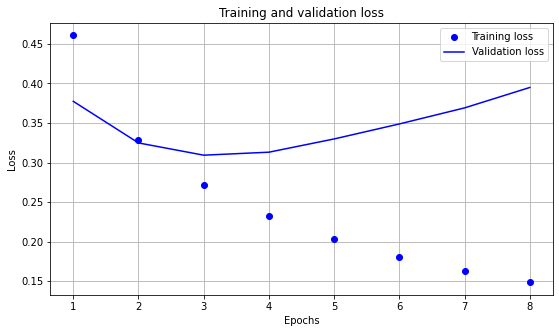

In [39]:
# "bo" is for "blue dot"
plt.figure(figsize=(9, 5))
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.show()

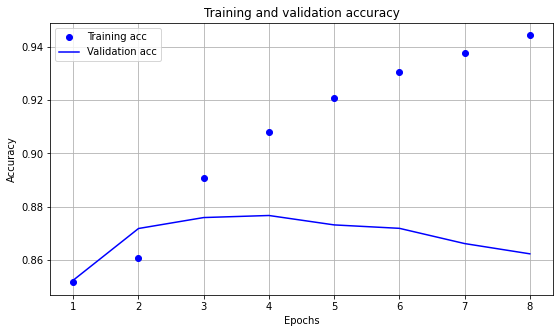

In [40]:
plt.figure(figsize=(9, 5))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

In [41]:
def print_my_examples(inputs, results, actual_values=None, limit=None):
    if actual_values is None:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}' for i in range(len(inputs))]
    else:
        result_for_printing = [f'input:\n"{inputs[i]}"\nscore: {results[i][0]:.6f}\nactual value:{actual_values[i]}' for i in range(len(inputs))]
    if limit:
        result_for_printing = result_for_printing[:limit]
    print(*result_for_printing, sep='\n\n')

In [42]:
inputs = x_train[:10]
outputs = y_train[:10]
results = tf.sigmoid(model.predict(tf.constant(inputs)))
print_my_examples(inputs, results, outputs)

input:
"with Mat  Prophecy of Kings"
score: 0.999622
actual value:1

input:
"Very very good game. Similar to base game of 3rd edition with balance problems fixed. A couple of negatives preventing it from getting a 10:  Only 6 players Distant suns is needed to make beginning of game more interesting and not just about grabbing planets as quickly as possible. Needs more aggressive public objectives to avoid possibility of turtling. Missing the diversity of 3rd with all expansions.  Still a very very good game."
score: 0.998269
actual value:1

input:
"Exelente juego en solitario."
score: 0.995288
actual value:1

input:
"Beautiful game, with great cardplacement aspect. "
score: 0.995534
actual value:1

input:
"Co-op / solo board games have recently become an obsession of mine with Spirit Island at the forefront of my enjoyment. For a game with such a simple board and play area, the amount of strategic depth is incredible especially when playing with multiple spirits or friends. It does tak

In [43]:
## APPLY MODEL ON NON-RATED COMMENTS

In [44]:
not_rated_comments = not_rated_comments.sample(frac=1)
results = tf.sigmoid(model.predict(tf.constant(list(not_rated_comments.value.astype(str)))))
print_my_examples(list(not_rated_comments.value), results, limit=25)

input:
"Brittany, John, Kevin have played"
score: 0.975293

input:
"Great game; i enjoy playing alone as Automna or just playing two factions"
score: 0.615783

input:
"Invaders From Afar, Rise of Fenris, The Wind Gambit, Encounters"
score: 0.999866

input:
"Fully punched, only played once"
score: 0.991947

input:
"First impression: 7  Need to play this more."
score: 0.990545

input:
"Sundropped, fully painted heroes"
score: 0.998015

input:
"This game brought me one of my all-time favorite gaming memories.  "We haven't instilled enough fear" the gods said simultaneously.   Liked - It was a coop, but there was a lot of depth to the co-op iness.    Disliked - Way way way too many rules to get the point of the game across.   Also winning seemed like it depended on getting special cards.  Definitely need an app for that."
score: 0.765460

input:
"highly-rated, difficult, pretty, co-op game. theme is protecting against european invaders using elemental powers. sounds amazing. $55-60"
score:

## COMBINE RATED COMMENTS AND NOT-RATED COMMENTS WITH PREDICTED RATING

In [45]:
rated_comments['rating'] = rated_comments.rating.astype(float)
rated_comments_grouped = rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
rated_comments_grouped.columns = list(rated_comments_grouped.columns.map('_'.join))
rated_comments_grouped = rated_comments_grouped.reset_index()
print("rated_comments_grouped: ")
print(rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 159675 |          8.08 |           1140 |
| 162886 |          8.35 |           3509 |
| 167355 |          8.41 |           1791 |
| 167791 |          8.21 |           8222 |
| 169427 |          8.59 |            219 |


In [46]:
not_rated_comments['rating'] = [round(float(r[0])*10, 1) for r in results]

In [47]:
not_rated_comments['rating'] = not_rated_comments.rating.astype(float)
not_rated_comments_grouped = not_rated_comments.groupby('id').agg({'rating': ['mean', 'count']})
not_rated_comments_grouped.columns = list(not_rated_comments_grouped.columns.map('_'.join))
not_rated_comments_grouped = not_rated_comments_grouped.reset_index()
print("not_rated_comments_grouped: ")
print(not_rated_comments_grouped.head().to_markdown(index=False, floatfmt='.2f', tablefmt='github'))

not_rated_comments_grouped: 
|     id |   rating_mean |   rating_count |
|--------|---------------|----------------|
| 159675 |          8.25 |            125 |
| 162886 |          8.79 |            308 |
| 167355 |          9.25 |            217 |
| 167791 |          8.99 |            438 |
| 169427 |          8.94 |             71 |


In [48]:
grouped = rated_comments_grouped.merge(not_rated_comments_grouped, on='id', suffixes=('_review', '_comments'), how='outer')
grouped['id'] = grouped.id.astype(str)
grouped = grouped.merge(pd.DataFrame(hot_array), on='id', how='right')
grouped['rank'] = grouped['rank'].astype(int)
grouped['url'] = grouped['id'].apply(lambda x: f"https://boardgamegeek.com/boardgame/{x}")
grouped['fixed_rating'] = (grouped['rating_mean_review']*grouped['rating_count_review']+grouped['rating_mean_comments']*grouped['rating_count_comments']) /\
                            (grouped['rating_count_review']+grouped['rating_count_comments'])
grouped['thumbnail'] = grouped['thumbnail'].apply(lambda x: f'<img src="{x}" width="124" />')
grouped['name'] = grouped.apply(lambda x: f'<a href="{x["url"]}">{x["name"]}</a>', axis=1)

grouped = grouped[['thumbnail', 'name', 'rating_mean_review', 'rating_mean_comments', 'fixed_rating', 'rank', 'yearpublished']]

In [49]:
grouped.head()

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
0,"<img src=""https://cf.geekdo-images.com/oaD1ZQ3...","<a href=""https://boardgamegeek.com/boardgame/2...",8.105000,9.266667,8.492222,1,2021
1,"<img src=""https://cf.geekdo-images.com/6GqH14T...","<a href=""https://boardgamegeek.com/boardgame/3...",7.896159,8.560000,7.955887,2,2020
2,"<img src=""https://cf.geekdo-images.com/4dk54qE...","<a href=""https://boardgamegeek.com/boardgame/2...",7.376439,8.781818,7.478817,3,2017
3,"<img src=""https://cf.geekdo-images.com/Zdt8l4o...","<a href=""https://boardgamegeek.com/boardgame/2...",8.304901,9.021186,8.555707,4,2021
4,"<img src=""https://cf.geekdo-images.com/OcnPGq9...","<a href=""https://boardgamegeek.com/boardgame/3...",7.910526,8.760000,8.087500,5,2021


In [50]:
def display_topn(by, n=5, ascending=True):
    temp_df = grouped.sort_values(by, ascending=ascending).head(n)
    temp_df.index=list(range(1, n+1))
    return HTML(temp_df.to_html(escape=False, classes='table table-striped'))

In [51]:
# TOP N RANK
display_topn(by='rank', n=TOP_N)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Destinies,8.105000,9.266667,8.492222,1,2021
2,,Lost Ruins of Arnak,7.896159,8.560000,7.955887,2,2020
3,,Fantasy Realms,7.376439,8.781818,7.478817,3,2017
4,,Sleeping Gods,8.304901,9.021186,8.555707,4,2021
5,,The Adventures of Robin Hood,7.910526,8.760000,8.087500,5,2021


In [52]:
# TOP N REVIEW RANK
display_topn(by='rating_mean_review', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.500000,9.355556,9.477966,49,2021
2,,The Witcher: Old World,9.208333,9.714286,9.394737,45,2022
3,,Brass: Birmingham,8.688057,9.017904,8.718151,32,2018
4,,Gloomhaven: Jaws of the Lion,8.608075,8.620301,8.609296,20,2020
5,,Middara: Unintentional Malum – Act 1,8.590092,8.940845,8.675966,48,2019


In [53]:
# TOP N FIXED RANK
display_topn(by='fixed_rating', n=TOP_N, ascending=False)

,thumbnail,name,rating_mean_review,rating_mean_comments,fixed_rating,rank,yearpublished
1,,Chronicles of Drunagor: Age of Darkness,9.500000,9.355556,9.477966,49,2021
2,,The Witcher: Old World,9.208333,9.714286,9.394737,45,2022
3,,Mosaic: A Story of Civilization,7.000000,9.357143,9.062500,6,2022
4,,Stationfall,8.316667,9.507143,8.755263,26,2021
5,,Kemet: Blood and Sand,8.500000,8.885714,8.751163,33,2021


In [54]:
# model.save('saved_model\my_model')

In [55]:
# saved_model = tf.keras.models.load_model('saved_model\my_model')

In [56]:
# some examples on "long" comments vs short comments

In [57]:
# some long comments
not_rated_comments['comment_len'] = not_rated_comments['value'].str.len()
some_long_comments = not_rated_comments.query("comment_len>100 and comment_len<300").sample(frac=1).head(25).sort_values('rating')
results = tf.sigmoid(model.predict(tf.constant(list(some_long_comments.value))))
print_my_examples(list(some_long_comments.value), results)

input:
"8.20.18 - (1 play, 3p) Games that look this good are hard to resist sitting down to play. I’m not a huge worker placement fan, but this wasn’t too bad. Would play again."
score: 0.094948

input:
"From rules read:  If I 'remember' rightly, this concept of going through a pile and memorising which icon doesn't appear twice has actually appeared before in Bauza's Mystery Express.  Sadly, the focus is less on deductive processes, more on attention and recall, so do I need another memory game?"
score: 0.202678

input:
"Played this one with James Lin. Interested in trying it again sometime, but seems like a really hard coop."
score: 0.196005

input:
"Hoping for a chance to play for real. After playing along with several videos, Im pretty confident about the rules. Probably a lot of fun.  No solo option"
score: 0.273530

input:
"Would take in trade if complete, that is, no legacy aspects have been done, rendering it otherwise useless... unsure about this title though. "
score: 0.40887